In [318]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif

# Data Ingestion

In [349]:
!ls data

testdemographics.csv  testprevloans.csv      trainperf.csv
testperf.csv	      traindemographics.csv  trainprevloans.csv


### The test data have no labels, so in this project, we will use only the train dataset.

## Training data

### Demographics data

In [350]:
df_demo = pd.read_csv("data/traindemographics.csv").drop_duplicates()

In [351]:
df_demo.columns

Index(['customerid', 'birthdate', 'bank_account_type', 'longitude_gps',
       'latitude_gps', 'bank_name_clients', 'bank_branch_clients',
       'employment_status_clients', 'level_of_education_clients'],
      dtype='object')

In [352]:
print(df_demo.shape)
print(df_demo.customerid.nunique())

(4334, 9)
4334


In [353]:
df_demo.isnull().sum()

customerid                       0
birthdate                        0
bank_account_type                0
longitude_gps                    0
latitude_gps                     0
bank_name_clients                0
bank_branch_clients           4283
employment_status_clients      648
level_of_education_clients    3748
dtype: int64

In [354]:
df_demo.dtypes

customerid                     object
birthdate                      object
bank_account_type              object
longitude_gps                 float64
latitude_gps                  float64
bank_name_clients              object
bank_branch_clients            object
employment_status_clients      object
level_of_education_clients     object
dtype: object

- Change 'birthdate' data type of date
- Drop 'bank_branch_clients' and 'level_of_education_clients' columns, they contain more than 50% missing values
- Replace the null values in 'employment_status_clients' with string 'UNKNOWN'

In [355]:
df_demo['birthdate'] = pd.to_datetime(df_demo['birthdate']).dt.date
df_demo = df_demo.drop(columns=['bank_branch_clients', 'level_of_education_clients'])
df_demo["employment_status_clients"] = df_demo["employment_status_clients"].fillna("UNKNOWN")

In [356]:
df_demo.head()

,customerid,birthdate,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,employment_status_clients
0,8a858e135cb22031015cbafc76964ebd,1973-10-10,Savings,3.319219,6.528604,GT Bank,UNKNOWN
1,8a858e275c7ea5ec015c82482d7c3996,1986-01-21,Savings,3.325598,7.119403,Sterling Bank,Permanent
2,8a858e5b5bd99460015bdc95cd485634,1987-04-01,Savings,5.746100,5.563174,Fidelity Bank,UNKNOWN
3,8a858efd5ca70688015cabd1f1e94b55,1991-07-19,Savings,3.362850,6.642485,GT Bank,Permanent
4,8a858e785acd3412015acd48f4920d04,1982-11-22,Savings,8.455332,11.971410,GT Bank,Permanent


### Previous Loans data

In [357]:
df_prev = pd.read_csv("data/trainprevloans.csv").drop_duplicates()

In [358]:
df_prev.columns

Index(['customerid', 'systemloanid', 'loannumber', 'approveddate',
       'creationdate', 'loanamount', 'totaldue', 'termdays', 'closeddate',
       'referredby', 'firstduedate', 'firstrepaiddate'],
      dtype='object')

In [359]:
print(df_prev.shape)
print(df_prev.customerid.nunique())

(18183, 12)
4359


In [360]:
df_prev.isnull().sum()

customerid             0
systemloanid           0
loannumber             0
approveddate           0
creationdate           0
loanamount             0
totaldue               0
termdays               0
closeddate             0
referredby         17157
firstduedate           0
firstrepaiddate        0
dtype: int64

In [361]:
df_prev.dtypes

customerid          object
systemloanid         int64
loannumber           int64
approveddate        object
creationdate        object
loanamount         float64
totaldue           float64
termdays             int64
closeddate          object
referredby          object
firstduedate        object
firstrepaiddate     object
dtype: object

- Drop `referredby` columns, it contains mostly null values
- Change data type of `approveddate`,`creationdate`, `closeddate`, `firstduedate`, `firstrepaiddate` to date

In [362]:
df_prev = df_prev.drop(columns=['referredby'])
df_prev['approveddate'] = pd.to_datetime(df_prev['approveddate'])
df_prev['creationdate'] = pd.to_datetime(df_prev['creationdate'])
df_prev['closeddate'] = pd.to_datetime(df_prev['closeddate'])
df_prev['firstduedate'] = pd.to_datetime(df_prev['firstduedate'])
df_prev['firstrepaiddate'] = pd.to_datetime(df_prev['firstrepaiddate'])

### Feature Engineering

- For each loan check if customer defaulted on first payment or exceeded the loan term days.

In [363]:
df_prev["first_payment_default"] = ((df_prev.firstrepaiddate.dt.normalize() - df_prev.firstduedate.dt.normalize()).dt.days > 0).astype(int)
df_prev["loan_default"] = ((df_prev.closeddate.dt.normalize() - df_prev.approveddate.dt.normalize()).dt.days > df_prev.termdays).astype(int)

In [364]:
df_prev.dtypes

customerid                       object
systemloanid                      int64
loannumber                        int64
approveddate             datetime64[ns]
creationdate             datetime64[ns]
loanamount                      float64
totaldue                        float64
termdays                          int64
closeddate               datetime64[ns]
firstduedate             datetime64[ns]
firstrepaiddate          datetime64[ns]
first_payment_default             int64
loan_default                      int64
dtype: object

- - Group all previous loans by `customerid` and compute aggregations for `loan number`, `loan amount`, `total due`, `term days`, `loan default`, and `first payment defaults` using the aggregation functions: `min`, `mean`, `max`, and `sum`.

In [365]:
grouped_prev = df_prev.groupby('customerid').agg({
    'loannumber': 'max',
    'loanamount': ['min', 'mean', 'max'],
    'totaldue': ['min', 'mean', 'max'],
    'termdays': ['min', 'mean', 'max'],
    'loan_default': 'sum',
    'first_payment_default': 'sum'
}).reset_index()

# Flatten column names
grouped_prev.columns = ['_'.join(col).strip() for col in grouped_prev.columns.values]
grouped_prev.rename(columns={'customerid_': 'customerid'}, inplace=True)

In [366]:
grouped_prev.head()

,customerid,loannumber_max,loanamount_min,loanamount_mean,loanamount_max,totaldue_min,totaldue_mean,totaldue_max,termdays_min,termdays_mean,termdays_max,loan_default_sum,first_payment_default_sum
0,8a1088a0484472eb01484669e3ce4e0b,1,10000.0,10000.000000,10000.0,11500.0,11500.000000,11500.0,15,15.000000,15,1,1
1,8a1a1e7e4f707f8b014f797718316cad,4,10000.0,17500.000000,30000.0,13000.0,22375.000000,39000.0,30,37.500000,60,1,1
2,8a1a32fc49b632520149c3b8fdf85139,7,10000.0,12857.142857,20000.0,11500.0,15214.285714,24500.0,15,19.285714,30,1,1
3,8a1eb5ba49a682300149c3c068b806c7,8,10000.0,16250.000000,30000.0,13000.0,20300.000000,39000.0,30,33.750000,60,0,1
4,8a1edbf14734127f0147356fdb1b1eb2,2,10000.0,10000.000000,10000.0,11500.0,12250.000000,13000.0,15,22.500000,30,0,0


### Performance data

In [367]:
df_perf = pd.read_csv("data/trainperf.csv").drop_duplicates()

In [368]:
df_perf.columns

Index(['customerid', 'systemloanid', 'loannumber', 'approveddate',
       'creationdate', 'loanamount', 'totaldue', 'termdays', 'referredby',
       'good_bad_flag'],
      dtype='object')

In [369]:
print(df_perf.shape)
print(df_perf.customerid.nunique())

(4368, 10)
4368


In [370]:
df_perf.isnull().sum()

customerid          0
systemloanid        0
loannumber          0
approveddate        0
creationdate        0
loanamount          0
totaldue            0
termdays            0
referredby       3781
good_bad_flag       0
dtype: int64

In [371]:
df_perf.dtypes

customerid        object
systemloanid       int64
loannumber         int64
approveddate      object
creationdate      object
loanamount       float64
totaldue         float64
termdays           int64
referredby        object
good_bad_flag     object
dtype: object

- Drop `referredby` columns, it contains mostly null values
- Change data type of `approveddate`, `creationdate` to date 
- Encode `good_bad_flag` to binary

In [372]:
df_perf = df_perf.drop(columns=['referredby'])
df_perf['approveddate'] = pd.to_datetime(df_perf['approveddate']).dt.date
df_perf['creationdate'] = pd.to_datetime(df_perf['creationdate']).dt.date
df_perf["good_bad_flag"] = df_perf.good_bad_flag.map({"Good": 1, "Bad": 0})

### Merge datasets

- Combine all three datasets to create the final training dataset for the model.

In [373]:
df_loans = pd.merge(df_perf, grouped_prev, on="customerid", how='left')
df_train = pd.merge(df_loans,df_demo, on="customerid", how='left')

In [374]:
# Drop dates
df_train = df_train.drop(columns=['approveddate', 'creationdate'])

In [375]:
df_train.head()

,customerid,systemloanid,loannumber,loanamount,totaldue,termdays,good_bad_flag,loannumber_max,loanamount_min,loanamount_mean,...,termdays_mean,termdays_max,loan_default_sum,first_payment_default_sum,birthdate,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,employment_status_clients
0,8a2a81a74ce8c05d014cfb32a0da1049,301994762,12,30000.0,34500.0,30,1,11.0,10000.0,18181.818182,...,30.0,30.0,4.0,3.0,1972-01-15,Other,3.432010,6.433055,Diamond Bank,Permanent
1,8a85886e54beabf90154c0a29ae757c0,301965204,2,15000.0,17250.0,30,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1985-08-23,Savings,3.885298,7.320700,GT Bank,Permanent
2,8a8588f35438fe12015444567666018e,301966580,7,20000.0,22250.0,15,1,6.0,10000.0,10000.000000,...,17.5,30.0,1.0,1.0,1984-09-18,Other,11.139350,10.292041,EcoBank,Permanent
3,8a85890754145ace015429211b513e16,301999343,3,10000.0,11500.0,15,1,2.0,10000.0,10000.000000,...,22.5,30.0,2.0,2.0,1977-10-10,Savings,3.985770,7.491708,First Bank,Permanent
4,8a858970548359cc0154883481981866,301962360,9,40000.0,44000.0,30,1,8.0,10000.0,18750.000000,...,37.5,60.0,0.0,0.0,1986-09-07,Other,7.457913,9.076574,GT Bank,Permanent


In [376]:
df_train.shape

(4368, 25)

# Exploratory Data Analysis

## Descriptive Analysis

In [377]:
df_train.shape

(4368, 25)

In [378]:
df_train.isnull().sum()

customerid                      0
systemloanid                    0
loannumber                      0
loanamount                      0
totaldue                        0
termdays                        0
good_bad_flag                   0
loannumber_max                  9
loanamount_min                  9
loanamount_mean                 9
loanamount_max                  9
totaldue_min                    9
totaldue_mean                   9
totaldue_max                    9
termdays_min                    9
termdays_mean                   9
termdays_max                    9
loan_default_sum                9
first_payment_default_sum       9
birthdate                    1099
bank_account_type            1099
longitude_gps                1099
latitude_gps                 1099
bank_name_clients            1099
employment_status_clients    1099
dtype: int64

About 25% of the data samples have missing values for six features.
There are three options:
- Drop the six features with many missing values.
- Impute the missing values.
- Drop rows with missing values.
  
To impute missing values, we have to:
- Fill in the missing age with the nearest neighbour method
- Add UNKNOWN category for object types
- Encode missing lat and long with 0.
  
However, this version of the project proceeds by dropping all the missing rows. In a follow-up to this project, we will explore several strategies for handling missing values and see if they improve the result of the model from this work.

In [379]:
# Training dataset without missing values
use_train = df_train.dropna()
use_train.shape

(3264, 25)

In [380]:
# Extract age from birthdate
use_train["age"] = 2024 - pd.to_datetime(use_train['birthdate']).dt.year

/tmp/ipykernel_101352/2659945661.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_train["age"] = 2024 - pd.to_datetime(use_train['birthdate']).dt.year


In [381]:
# We drop id columns and the data of birth.
use_train.columns

Index(['customerid', 'systemloanid', 'loannumber', 'loanamount', 'totaldue',
       'termdays', 'good_bad_flag', 'loannumber_max', 'loanamount_min',
       'loanamount_mean', 'loanamount_max', 'totaldue_min', 'totaldue_mean',
       'totaldue_max', 'termdays_min', 'termdays_mean', 'termdays_max',
       'loan_default_sum', 'first_payment_default_sum', 'birthdate',
       'bank_account_type', 'longitude_gps', 'latitude_gps',
       'bank_name_clients', 'employment_status_clients', 'age'],
      dtype='object')

In [382]:
columns = ['loannumber', 'loanamount', 'totaldue', 'termdays', 'good_bad_flag', 'loannumber_max', 
           'loanamount_min', 'loanamount_mean', 'loanamount_max', 'totaldue_min', 'totaldue_mean', 
           'totaldue_max', 'termdays_min', 'termdays_mean', 'termdays_max', 'loan_default_sum', 
           'first_payment_default_sum','bank_account_type', 'longitude_gps', 'latitude_gps',
           'bank_name_clients', 'employment_status_clients', 'age']

In [383]:
# Drop ID features and birthdate
use_train = use_train[columns]
use_train.dtypes

loannumber                     int64
loanamount                   float64
totaldue                     float64
termdays                       int64
good_bad_flag                  int64
loannumber_max               float64
loanamount_min               float64
loanamount_mean              float64
loanamount_max               float64
totaldue_min                 float64
totaldue_mean                float64
totaldue_max                 float64
termdays_min                 float64
termdays_mean                float64
termdays_max                 float64
loan_default_sum             float64
first_payment_default_sum    float64
bank_account_type             object
longitude_gps                float64
latitude_gps                 float64
bank_name_clients             object
employment_status_clients     object
age                            int32
dtype: object

In [384]:
use_train.head()

,loannumber,loanamount,totaldue,termdays,good_bad_flag,loannumber_max,loanamount_min,loanamount_mean,loanamount_max,totaldue_min,...,termdays_mean,termdays_max,loan_default_sum,first_payment_default_sum,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,employment_status_clients,age
0,12,30000.0,34500.0,30,1,11.0,10000.0,18181.818182,30000.0,13000.0,...,30.0,30.0,4.0,3.0,Other,3.432010,6.433055,Diamond Bank,Permanent,52
2,7,20000.0,22250.0,15,1,6.0,10000.0,10000.000000,10000.0,11500.0,...,17.5,30.0,1.0,1.0,Other,11.139350,10.292041,EcoBank,Permanent,40
3,3,10000.0,11500.0,15,1,2.0,10000.0,10000.000000,10000.0,11500.0,...,22.5,30.0,2.0,2.0,Savings,3.985770,7.491708,First Bank,Permanent,47
4,9,40000.0,44000.0,30,1,8.0,10000.0,18750.000000,30000.0,13000.0,...,37.5,60.0,0.0,0.0,Other,7.457913,9.076574,GT Bank,Permanent,38
6,3,10000.0,13000.0,30,1,2.0,10000.0,10000.000000,10000.0,11500.0,...,22.5,30.0,0.0,0.0,Savings,3.259444,6.557011,GT Bank,Permanent,35


In [385]:
use_train.nunique()

loannumber                     22
loanamount                      9
totaldue                       46
termdays                        4
good_bad_flag                   2
loannumber_max                 22
loanamount_min                 10
loanamount_mean               236
loanamount_max                 10
totaldue_min                   35
totaldue_mean                 988
totaldue_max                   45
termdays_min                    3
termdays_mean                 137
termdays_max                    4
loan_default_sum               10
first_payment_default_sum      10
bank_account_type               3
longitude_gps                3130
latitude_gps                 3252
bank_name_clients              18
employment_status_clients       7
age                            36
dtype: int64

In [386]:
# Summary satistics of Numerical Features
use_train.describe().T

,count,mean,std,min,25%,50%,75%,max
loannumber,3264.0,5.193934,3.668213,2.000000,2.000000,4.000000,7.000000,27.000000
loanamount,3264.0,17841.605392,10746.274326,10000.000000,10000.000000,10000.000000,20000.000000,60000.000000
totaldue,3264.0,21290.954504,11930.907156,10000.000000,13000.000000,13000.000000,24500.000000,68100.000000
termdays,3264.0,29.246324,11.397130,15.000000,30.000000,30.000000,30.000000,90.000000
good_bad_flag,3264.0,0.782169,0.412835,0.000000,1.000000,1.000000,1.000000,1.000000
loannumber_max,3264.0,4.193321,3.667327,1.000000,1.000000,3.000000,6.000000,26.000000
loanamount_min,3264.0,9891.544118,987.759380,3000.000000,10000.000000,10000.000000,10000.000000,30000.000000
loanamount_mean,3264.0,12946.446574,4853.360035,5000.000000,10000.000000,10000.000000,14444.444444,36666.666667
loanamount_max,3264.0,16979.166667,10376.229101,5000.000000,10000.000000,10000.000000,20000.000000,60000.000000
totaldue_min,3264.0,12006.839767,1440.619836,3900.000000,11500.000000,11500.000000,13000.000000,39000.000000


In [387]:
# Summary satistics of Categorical features
use_train.describe(include='object').T

,count,unique,top,freq
bank_account_type,3264,3,Savings,2565
bank_name_clients,3264,18,GT Bank,1205
employment_status_clients,3264,7,Permanent,2335


In [388]:
# Variance of each numerical features
use_train.select_dtypes(include='number').var()

loannumber                   1.345579e+01
loanamount                   1.154824e+08
totaldue                     1.423465e+08
termdays                     1.298946e+02
good_bad_flag                1.704328e-01
loannumber_max               1.344928e+01
loanamount_min               9.756686e+05
loanamount_mean              2.355510e+07
loanamount_max               1.076661e+08
totaldue_min                 2.075386e+06
totaldue_mean                2.939658e+07
totaldue_max                 1.362617e+08
termdays_min                 5.592802e+01
termdays_mean                4.718078e+01
termdays_max                 1.537132e+02
loan_default_sum             1.823608e+00
first_payment_default_sum    1.389469e+00
longitude_gps                6.290752e+01
latitude_gps                 1.070628e+01
age                          3.755459e+01
dtype: float64

In [389]:
# Skew in numerical features
use_train.select_dtypes(include='number').skew()

loannumber                   1.317322
loanamount                   1.240059
totaldue                     1.152691
termdays                     1.879422
good_bad_flag               -1.367820
loannumber_max               1.316383
loanamount_min               5.327251
loanamount_mean              1.745952
loanamount_max               1.340488
totaldue_min                 3.836837
totaldue_mean                1.708770
totaldue_max                 1.256846
termdays_min                 0.365366
termdays_mean                0.018740
termdays_max                 1.513642
loan_default_sum             1.941052
first_payment_default_sum    2.309080
longitude_gps               -3.205028
latitude_gps                 9.351353
age                          0.691620
dtype: float64

<b>
Observations:
    
- There are 3264 instances and 25 features: 22 numeric and 3 categorical.
- Latitude and longitude features have the most variance, while the rest have less than 100 unique values.
- The variance is generally low, least in loanamount_max and most in loan_default_sum.
- age, termdays_min, and termdays_mean have a moderate range of positive skew.
- longitude_gps has a high negative skew.
- The remaining features show  a high  positive skew (>1).
</b>

## Correlation Analysis

In [390]:
corr = use_train.select_dtypes(include="number").corr()

<Axes: >

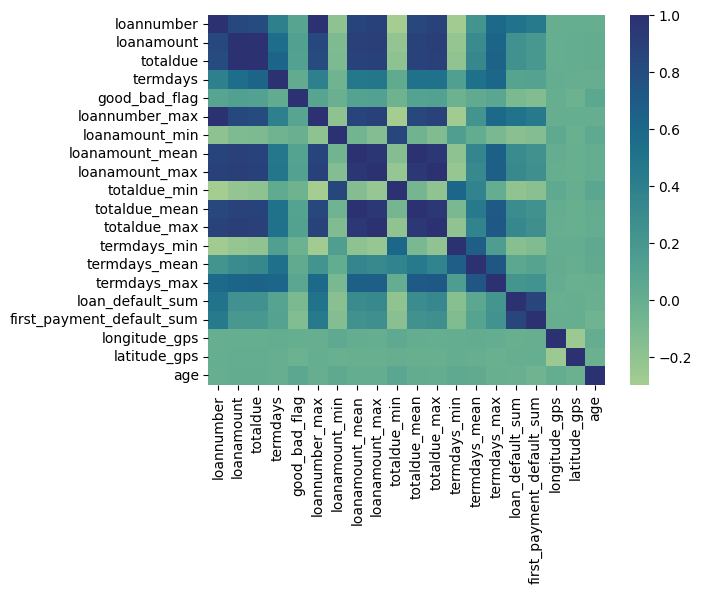

In [391]:
sns.heatmap(corr, cmap="crest")

- A lot of the features are correlated with each other:
    - Totaldue and loan amount are almost perfectly correlated; this is a case of redundancy.
    - Loan number and loanamount, loanamount_mean, loanamount_max are almost perfectly correlated; this is a case of redundancy.
    - Term days features show moderate correlations with loan amounts
    - GPS coordinates (longitude and latitude) are correlated with each other but show weak correlations with other features
    - Loan default and first payment default sums show some correlation with each other
    - Age appears to have relatively weak correlations with most other features


### Feature Selection

In [392]:
y = use_train["good_bad_flag"].astype(int)

In [393]:
# Check feature relevance of numeric features with mutual information
for col in use_train.select_dtypes(include="number").columns:
    if col!="good_bad_flag":
        mi = mutual_info_classif(use_train[[col]], y.values)
        print(f"{col}: {round(mi[0],6)}")

loannumber: 0.001594
loanamount: 0.000919
totaldue: 0.009969
termdays: 0
loannumber_max: 0.014471
loanamount_min: 0.007314
loanamount_mean: 0.013209
loanamount_max: 0.012437
totaldue_min: 0
totaldue_mean: 0.017581
totaldue_max: 0.015188
termdays_min: 0
termdays_mean: 0
termdays_max: 0.002165
loan_default_sum: 0.01761
first_payment_default_sum: 0.027786
longitude_gps: 0.002436
latitude_gps: 0.002058
age: 0


<b>
    
Observations:   

- The numerical features show only little correlation with the target.

- Order of feature relevance is:
    
    - totaldue: 0.019405
    - totaldue_max: 0.016125
    - first_payment_default_sum: 0.015909
    - loanamount: 0.009128
    - termdays_min: 0.008171
    - loanamount_max: 0.008191
    - loan_default_sum: 0.007087
    - totaldue_min: 0.007041
    - age: 0.007007
    - loannumber_max: 0.006998
   - totaldue_mean: 0.006899
    - loannumber: 0.00657
    - termdays: 0.003715
    - loanamount_mean: 0.003425
    - longitude_gps: 0.002828
    - loanamount_min: 0.001126
    - latitude_gps: 0.00204
    - termdays_max: 0.000071
    - termdays_mean: 0

- Action:
    - Drop loanamount and the engineered features: loanamount_max, loanamount_mean, loanamount_min
    - Drop totaldue_mean, totaldue_max, they are highly correlated with totaldue
    - Drop loan_default_sum, it's highly correlated with first_payment_default_sum
    - Drop termdays_max, termdays_mean, they are least informative to the target
    - Drop loannumber which is hight correlated with loannumber_max


</b>

In [394]:
# Drop redundant features
use_train = use_train.drop(columns=["loanamount","loanamount_max", "loanamount_mean", "loanamount_min",
                                   "totaldue_mean", "totaldue_max", "loan_default_sum", "termdays_max", 
                                    "termdays_mean", "loannumber"])

## Distribution Analysis

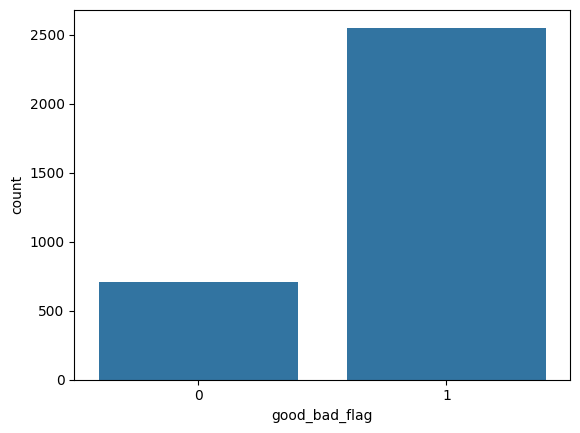

In [395]:
# Distribution of target
sns.countplot(use_train, x="good_bad_flag");

- good(1) --> settled loan on time; bad(0) --> did not settled loan on time

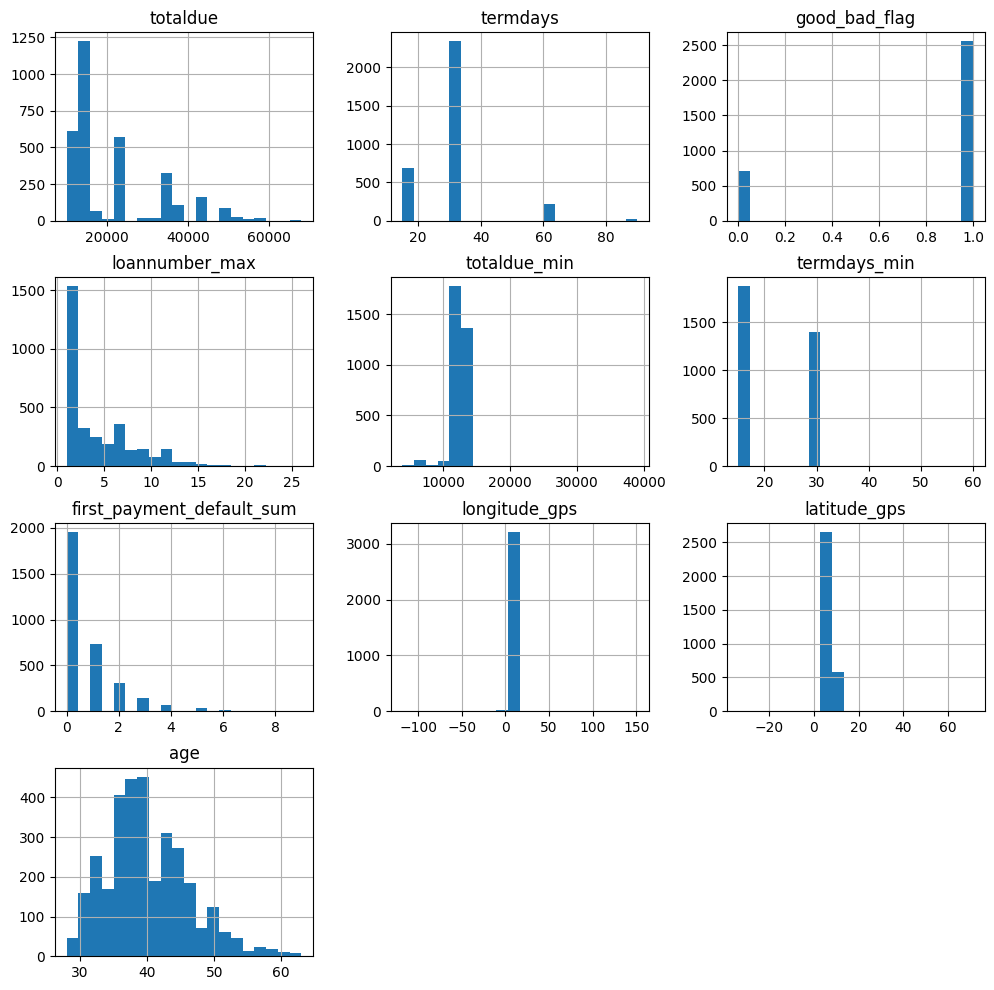

In [396]:
use_train.select_dtypes(include="number").hist(figsize=(12,12),bins=20)
plt.show()


bank_account_type



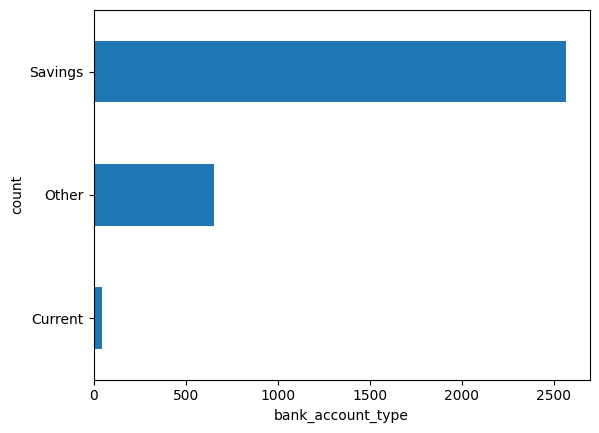


bank_name_clients



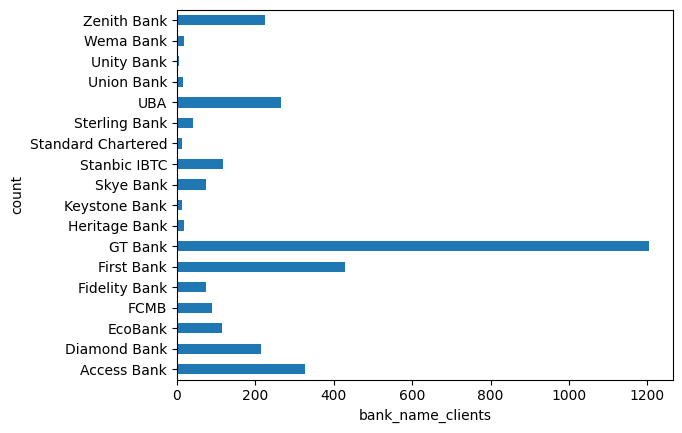


employment_status_clients



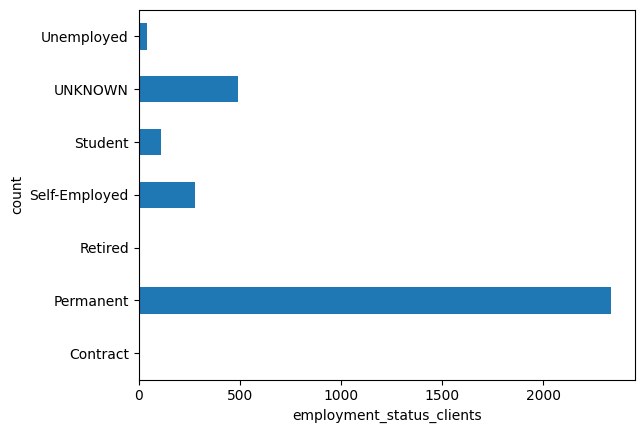

In [397]:
# Generate bar plots of unique value counts in each categorical feature
for col in use_train.select_dtypes(exclude="number").columns:
    print()
    print(f"\033[1m{col}\033[0m\n") #print column name above the plot
    use_train[col].value_counts().sort_index().plot(kind='barh', rot=0, xlabel=col,ylabel='count')
    plt.show()

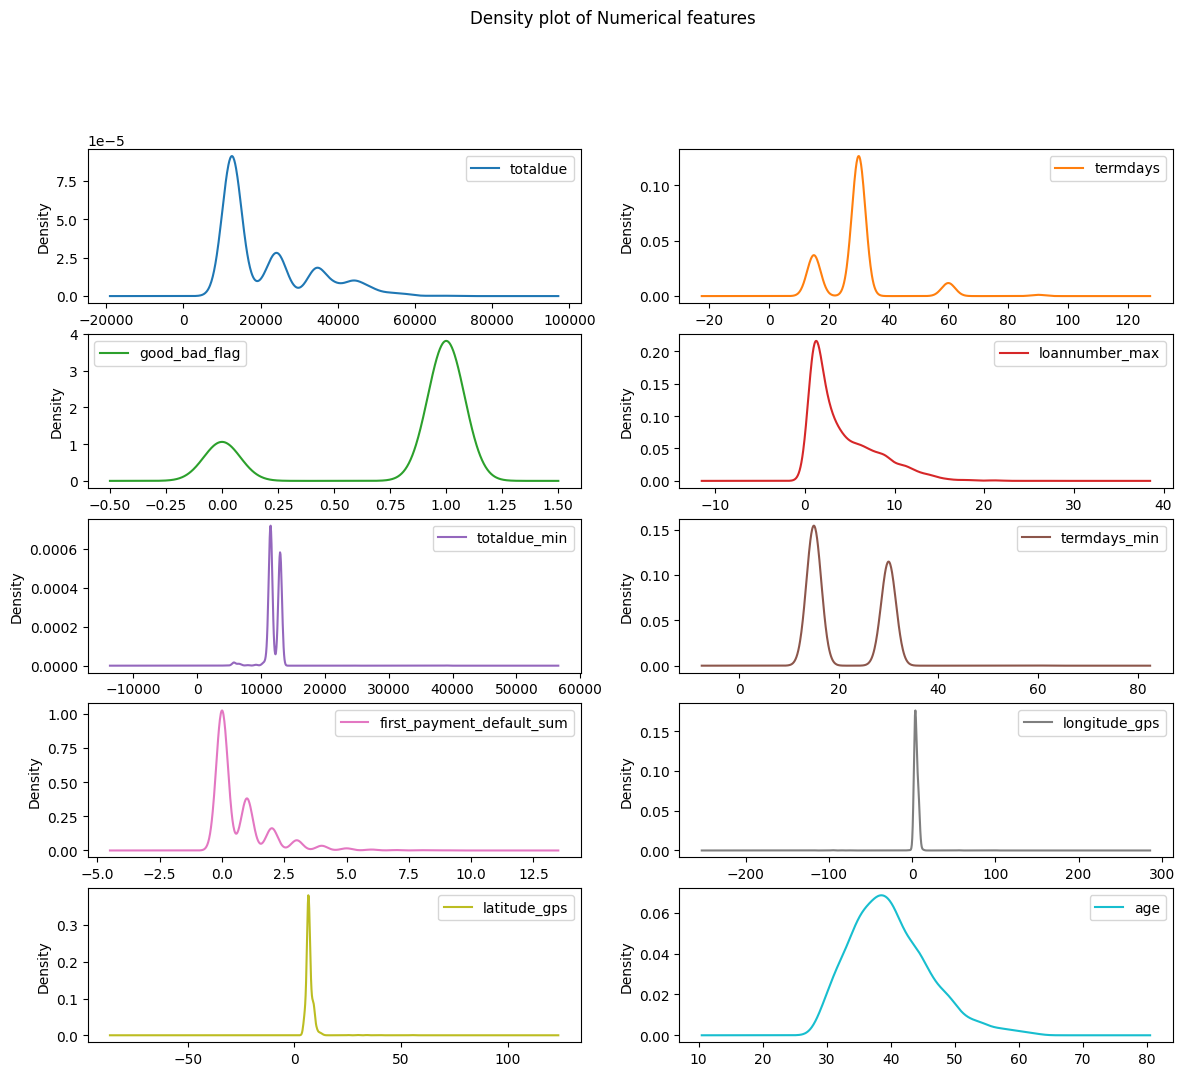

In [398]:
use_train.select_dtypes(include="number").plot(kind='density',figsize=(14,14),subplots=True,layout=(6,2),title="Density plot of Numerical features",sharex=False)
plt.show()

<b>
    
Observations:   
- There is a class imbalance, with the majority(76%) of the instances in the dataset being good while a minority(24%) is bad.
- With the class imbalance, metrics like AUC, recall, and F1 are more suitable.
- Most loans are low amounts (10,000 naira) and for 30 days.
- The distribution of most of the features is not Gaussian (age is the closest to having a Gaussian distribution).
- For the categorical variables:
    - Most applicants have savings(64%) accounts, a permanent employment(68%) and are from GT bank(37%).
 </b>

### Final pre-processing

In [61]:
# Transform categorical variables to numerical ones with encoding 
# For the bank_account_type feature, we consider two levels --> savings and others
# For the bank_name_clients feature, we consider five levels (banks) --> GT, First, (Diamond & Access), UBA, and Zenith
# For the employment_status_clients feature, we consider three levels --> permanent, self-employed, and others

In [401]:
print(use_train['bank_name_clients'].unique())

['Diamond Bank' 'EcoBank' 'First Bank' 'GT Bank' 'Access Bank' 'UBA'
 'Union Bank' 'FCMB' 'Zenith Bank' 'Stanbic IBTC' 'Fidelity Bank'
 'Wema Bank' 'Sterling Bank' 'Skye Bank' 'Keystone Bank' 'Heritage Bank'
 'Unity Bank' 'Standard Chartered']


In [402]:
banks_of_interest = ['GT Bank', 'First Bank', 'Access_Diamond', 'UBA', 'Zenith Bank']
status_of_interest = ['Permanent', 'Self-Employed']
use_train['bank_name_clients'] = use_train['bank_name_clients'].replace({'Diamond Bank': 'Access_Diamond', 'Access Bank': 'Access_Diamond'})

# bank_account_type
use_train['bank_account_num'] = np.where(use_train['bank_account_type'] == 'Savings', 1, 0)

# Create dummy variables for banks
bank_encoded = pd.get_dummies(use_train['bank_name_clients'], dtype=float)
bank_encoded = bank_encoded[banks_of_interest].add_prefix('is_')

# Create dummy variables for employment status
status_encoded = pd.get_dummies(use_train['employment_status_clients'], dtype=float)
status_encoded = status_encoded[status_of_interest].add_prefix('is_')

# Combine the original dataframe with encoded columns
use_train = pd.concat([use_train, bank_encoded, status_encoded], axis=1)

In [403]:
use_train = use_train.drop(columns=['bank_account_type', 'bank_name_clients', "employment_status_clients"])

In [404]:
use_train.head()

,totaldue,termdays,good_bad_flag,loannumber_max,totaldue_min,termdays_min,first_payment_default_sum,longitude_gps,latitude_gps,age,bank_account_num,is_GT Bank,is_First Bank,is_Access_Diamond,is_UBA,is_Zenith Bank,is_Permanent,is_Self-Employed
0,34500.0,30,1,11.0,13000.0,30.0,3.0,3.432010,6.433055,52,0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,22250.0,15,1,6.0,11500.0,15.0,1.0,11.139350,10.292041,40,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,11500.0,15,1,2.0,11500.0,15.0,2.0,3.985770,7.491708,47,1,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,44000.0,30,1,8.0,13000.0,30.0,0.0,7.457913,9.076574,38,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
6,13000.0,30,1,2.0,11500.0,15.0,0.0,3.259444,6.557011,35,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [405]:
# Check feature relevance again now that all features are numeric
for col in use_train.select_dtypes(include="number").columns:
    if col!="good_bad_flag":
        mi = mutual_info_classif(use_train[[col]], y.values)
        print(f"{col}: {round(mi[0],6)}")

totaldue: 0.019317
termdays: 0.002308
loannumber_max: 0.006084
totaldue_min: 0.011084
termdays_min: 0
first_payment_default_sum: 0.028425
longitude_gps: 0.002562
latitude_gps: 0.001963
age: 0.006421
bank_account_num: 0.002135
is_GT Bank: 0
is_First Bank: 0
is_Access_Diamond: 0.012418
is_UBA: 0.001086
is_Zenith Bank: 0.007862
is_Permanent: 0.001222
is_Self-Employed: 0


In [407]:
corr = use_train.select_dtypes(include="number").corr()

<Axes: >

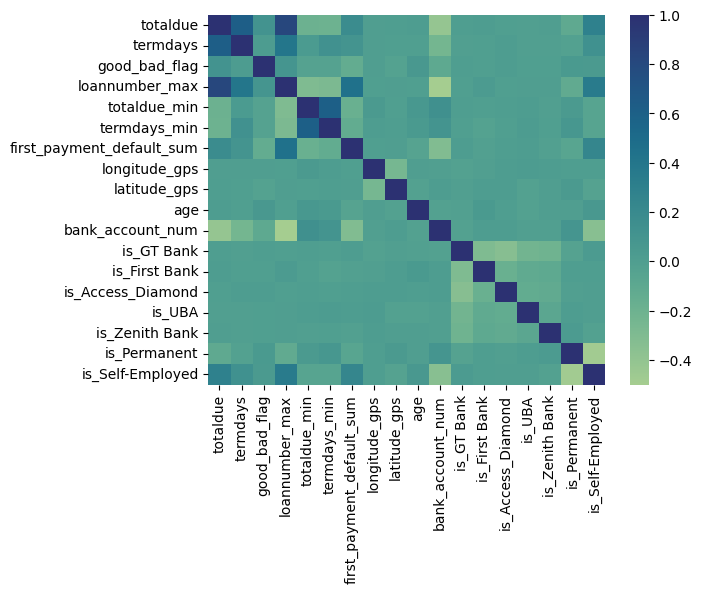

In [408]:
sns.heatmap(corr, cmap="crest")

**Summary:** 

The dataset comprises 3,264 instances with 25 features (22 numeric, 3 categorical), exhibiting significant class imbalance with 76% good loans and 24% bad loans. Among the features, GPS coordinates (latitude and longitude) show the highest variance and relevance, while financial features like totaldue and loan amount display perfect correlation, indicating redundancy. Most numerical features demonstrate high positive skew (>1), except for age (moderate positive) and longitude_gps (high negative), with generally low correlation to the target variable. The data reveals that typical loans are for 30 days at 10,000 naira, and most applicants have savings accounts (64%), permanent employment (68%), and primarily bank with GT bank (37%). Given the class imbalance characteristics, performance metrics such as AUC, recall, and F1 score would be more appropriate for evaluation than traditional accuracy measures.

## Model Selection

- Models compared for selection are:
    - Logistic regression with lasso regularization
    - Support vector machine
    - Stochastic gradient descent
    - KNearest Neighbour
    - Naive Bayes
    - Decision Tree
    - Random Forest
    - Gradient Boosting
    - XGBoost 

In [409]:
X = use_train.drop(columns=["good_bad_flag"])
y = use_train.good_bad_flag
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [410]:
from sklearn.linear_model import LogisticRegression

In [415]:
lasso_clf = LogisticRegression(penalty='l1', solver='liblinear', random_state=42)

In [416]:
lasso_auc  =np.average(cross_val_score(lasso_clf, X_train, y_train, cv=10, scoring='roc_auc'))
lasso_acc  =np.average(cross_val_score(lasso_clf, X_train, y_train, cv=10, scoring='accuracy'))

In [430]:
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [431]:
svm_clf = make_pipeline(StandardScaler(), LinearSVC(random_state=42))
svm_auc = np.average(cross_val_score(svm_clf, X_train, y_train, cv=10, scoring='roc_auc'))
svm_acc = np.average(cross_val_score(svm_clf, X_train, y_train, cv=10, scoring='accuracy'))

In [432]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(loss="hinge", penalty="l2", max_iter=500, random_state=42)
sgd_auc = np.average(cross_val_score(sgd_clf, X_train, y_train, cv=10, scoring='roc_auc'))
sgd_acc = np.average(cross_val_score(sgd_clf, X_train, y_train, cv=10, scoring='accuracy'))

In [433]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=5))
knn_auc = np.average(cross_val_score(knn_clf, X_train, y_train, cv=10, scoring='roc_auc'))
knn_acc = np.average(cross_val_score(knn_clf, X_train, y_train, cv=10, scoring='accuracy'))

In [437]:
from sklearn.naive_bayes import GaussianNB
nb_clf = GaussianNB()
nb_auc = np.average(cross_val_score(nb_clf, X_train, y_train, cv=10, scoring='roc_auc'))
nb_acc = np.average(cross_val_score(nb_clf, X_train, y_train, cv=10, scoring='accuracy'))

In [453]:
from sklearn import tree
dt_clf = tree.DecisionTreeClassifier(random_state=42, max_depth=4)
dt_auc = np.average(cross_val_score(dt_clf, X_train, y_train, cv=10, scoring='roc_auc'))
dt_acc = np.average(cross_val_score(dt_clf, X_train, y_train, cv=10, scoring='accuracy'))

In [467]:
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(random_state=42, max_depth=7)
rf_auc = np.average(cross_val_score(rf_clf, X_train, y_train, cv=10, scoring='roc_auc'))
rf_acc = np.average(cross_val_score(rf_clf, X_train, y_train, cv=10, scoring='accuracy'))

In [479]:
from sklearn.ensemble import GradientBoostingClassifier
gb_clf = GradientBoostingClassifier(random_state=42, max_depth=3)
gb_auc = np.average(cross_val_score(gb_clf, X_train, y_train, cv=10, scoring='roc_auc'))
gb_acc = np.average(cross_val_score(gb_clf, X_train, y_train, cv=10, scoring='accuracy'))

In [498]:
import xgboost as xgb

# Create DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train)

# Define parameters
params = {
    'objective': 'binary:logistic',
    'eval_metric': ['auc', 'error'],  # Include both AUC and error (1 - accuracy)
    'seed': 42
}

# Perform cross-validation
cv_results = xgb.cv(
    params,
    dtrain,
    num_boost_round=14,
    nfold=10,
    metrics=['auc', 'error'],  # Specify metrics for evaluation
    as_pandas=True
)

# Calculate and display results
xbg_auc = cv_results['test-auc-mean'].iloc[-1]
mean_error = cv_results['test-error-mean'].iloc[-1]
xgb_acc = 1 - mean_error  # Convert error to accuracy

In [499]:
columns = ["Model", "AUC", "Accuracy"]
models = ["Logistic", "SVM", "SGD", "KNN", "Naive Bayes", "Decision Tree", "Random Forest", "Gradient Boosting", "XGBoost"]
aucs = [lasso_auc, svm_auc, sgd_auc, knn_auc, nb_auc, dt_auc, rf_auc, gb_auc, xbg_auc]
accs = [lasso_acc, svm_acc, sgd_acc, knn_acc, nb_acc, dt_acc, rf_acc, gb_acc, xgb_acc]
model_performance = pd.DataFrame(zip(models, aucs, accs), columns=columns)

## Comparing model AUC

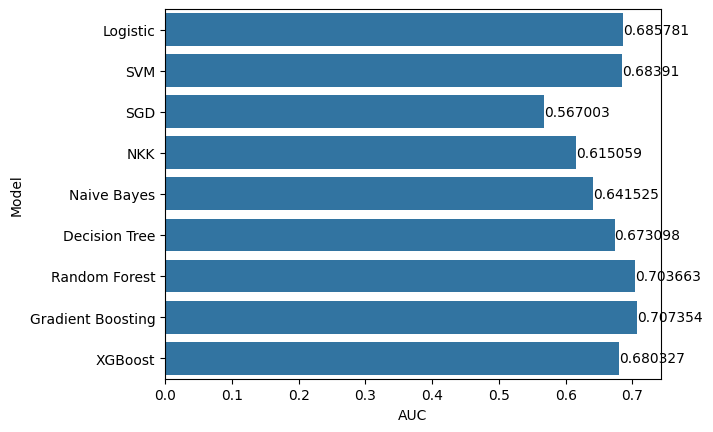

In [500]:
ax = sns.barplot(model_performance, x="AUC", y="Model")
ax.bar_label(ax.containers[0]);

Based on the AUC scores, the top-performing models are:

- Gradient Boosting
- Random Forest
- Logistic regression
- Support vector machine
- XGBoost

## Comparing model Accuracy

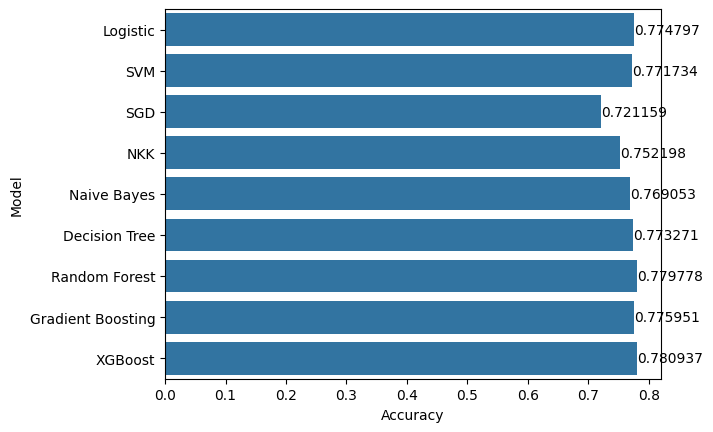

In [501]:
ax = sns.barplot(model_performance, x="Accuracy", y="Model")
ax.bar_label(ax.containers[0]);

Based on the AUC scores, the top-performing models are:

- XGBoost
- Random Forest
- Gradient Boosting
- Logistic regression
- Decision Tree


### Validaiton

- Validation is done on models that appear top performing bu AUC or Accuracy.

In [488]:
from sklearn.metrics import accuracy_score, roc_auc_score

In [507]:
gb_clf.fit(X_train, y_train)
y_pred = gb_clf.predict(X_val)
gb_auc_val = roc_auc_score(y_val, y_pred)
gb_acc_val = accuracy_score(y_val, y_pred)

In [508]:
lasso_clf.fit(X_train, y_train)
y_pred = lasso_clf.predict(X_val)
lasso_auc_val = roc_auc_score(y_val, y_pred)
lasso_acc_val = accuracy_score(y_val, y_pred)

In [509]:
rf_clf.fit(X_train, y_train)
y_pred = rf_clf.predict(X_val)
rf_auc_val = roc_auc_score(y_val, y_pred)
rf_acc_val = accuracy_score(y_val, y_pred)

In [510]:
dt_clf.fit(X_train, y_train)
y_pred = dt_clf.predict(X_val)
dt_auc_val = roc_auc_score(y_val, y_pred)
dt_acc_val = accuracy_score(y_val, y_pred)

In [511]:
svm_clf.fit(X_train, y_train)
y_pred = svm_clf.predict(X_val)
svm_auc_val = roc_auc_score(y_val, y_pred)
svm_acc_val = accuracy_score(y_val, y_pred)

In [515]:
import xgboost as xgb
from sklearn.metrics import roc_auc_score, accuracy_score

# Create DMatrix for training and validation
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

# Define parameters
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',  # Use log loss during training; calculate AUC and accuracy separately
    'seed': 42
}

# Train the model
model = xgb.train(params, dtrain, num_boost_round=14)

# Make predictions on the validation data
y_pred = model.predict(dval)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Calculate metrics
xgb_auc_val = roc_auc_score(y_val, y_pred)  # Use y_val for metrics
xgb_acc_val = accuracy_score(y_val, y_pred_binary)

In [521]:
columns = ["Model", "AUC", "Accuracy"]
models = ["Logistic", "SVM", "Decision Tree", "Random Forest", "Gradient Boosting", "XGBoost"]
aucs = [lasso_auc_val, svm_auc_val, dt_auc_val, rf_auc_val, gb_auc_val, xgb_auc_val]
accs = [lasso_auc_val, svm_acc_val, dt_acc_val, rf_acc_val, gb_acc_val, xgb_acc_val]
model_performance = pd.DataFrame(zip(models, aucs, accs), columns=columns)

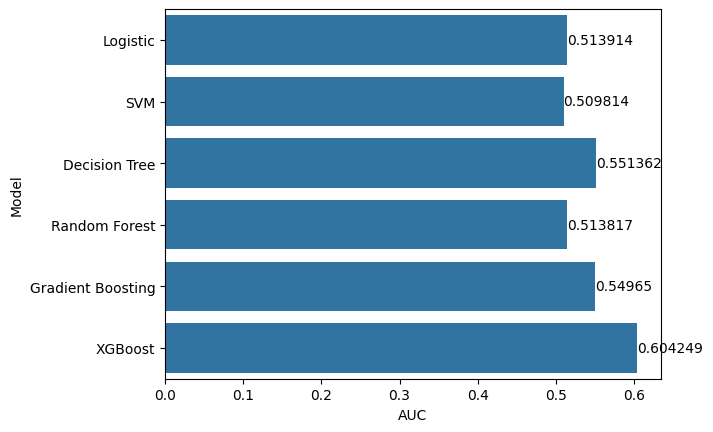

In [522]:
ax = sns.barplot(model_performance, x="AUC", y="Model")
ax.bar_label(ax.containers[0]);

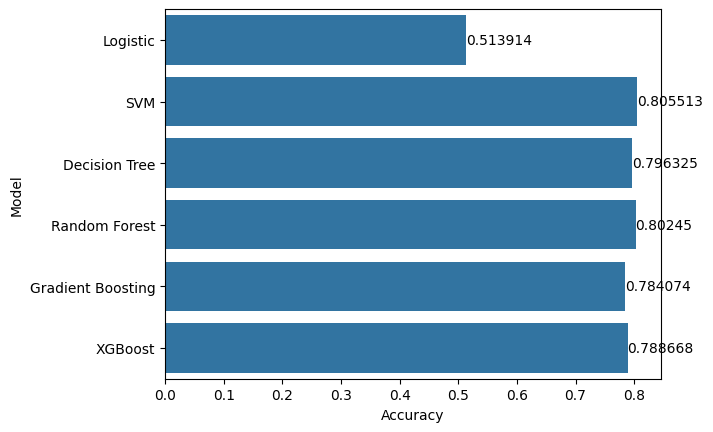

In [523]:
ax = sns.barplot(model_performance, x="Accuracy", y="Model")
ax.bar_label(ax.containers[0]);

- Taking both metrucs into consideration, **XGBoost** has the best performance.

In [553]:
X.columns

Index(['totaldue', 'termdays', 'loannumber_max', 'totaldue_min',
       'termdays_min', 'first_payment_default_sum', 'longitude_gps',
       'latitude_gps', 'age', 'bank_account_num', 'is_GT Bank',
       'is_First Bank', 'is_Access_Diamond', 'is_UBA', 'is_Zenith Bank',
       'is_Permanent', 'is_Self-Employed'],
      dtype='object')

### Parameter Tuning

In [547]:
dtrain = xgb.DMatrix(X, label=y)

max_depth = [1,2,3,4,5,6,7,8,9,10]
min_child_weight = [1,2,3,4,5]
gamma = [0, 0.1, 0.2, 0.3, 0.4, 0.5]

depths = []
weights = []
gammas = []
auc_scores = []
acc_scores = []
for depth in tqdm(max_depth):
    for child in min_child_weight:
        for gam in gamma:
            params = {'objective': 'binary:logistic',
                      'eval_metric': 'logloss', 
                      'seed': 42,
                      'gamma': gam,
                      'max_depth': depth,
                      'min_child_weight': child
                     }
            
            cv_results = xgb.cv(
                params,
                dtrain,
                num_boost_round=14,
                nfold=10,
                metrics=['auc', 'error'],  # Specify metrics for evaluation
                as_pandas=True
            )
            
            # Calculate and display results
            # Store parameters and results
            depths.append(depth)
            weights.append(child)
            gammas.append(gam)
            auc_scores.append(cv_results['test-auc-mean'].iloc[-1])
            acc_scores.append(1 - cv_results['test-error-mean'].iloc[-1])
            


100%|███████████████████████████████████████████| 10/10 [02:26<00:00, 14.69s/it]


In [548]:
df_tuning = pd.DataFrame({
    'max_depth': depths,
    'min_child_weight': weights,
    'gamma': gammas,
    'AUC': auc_scores,
    'Accuracy': acc_scores
})

In [549]:
df_tuning.shape

(300, 5)

In [551]:
df_tuning[df_tuning.AUC == df_tuning.AUC.max()]

,max_depth,min_child_weight,gamma,AUC,Accuracy
78,3,4,0.0,0.698672,0.785239
79,3,4,0.1,0.698672,0.785239


In [552]:
df_tuning[df_tuning.Accuracy == df_tuning.Accuracy.max()]

,max_depth,min_child_weight,gamma,AUC,Accuracy
145,5,5,0.1,0.686176,0.794432


## Train final model

In [ ]:
def transform(X_df):
    

In [ ]:
def train(X_train, y_train, n_estimators=400, max_depth=5):
    
    X_full = pd.get_dummies(X_train, drop_first=True, dtype=int)
    
    rf = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
    rf.fit(X_train, y_train)

    return rf

In [ ]:
def predict(X_test, model):
    X_full = pd.get_dummies(X_test, drop_first=True, dtype=int)
    y_pred = model.predict(X_test)

    return y_pred, np.expm1(y_pred)